In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import time
from torchvision import models
import random

In [2]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if hasattr(torch, "mps") and hasattr(torch.mps, "manual_seed_all"):
    torch.mps.manual_seed_all(seed)

torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

device = torch.device("mps" if torch.mps.is_available() else "cpu")
print("Device:", device)

CIFAR10_CLASSES = (
    'airplane','automobile','bird','cat','deer',
    'dog','frog','horse','ship','truck'
)

Device: mps


In [3]:
# Data loading and preprocessing
transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2, pin_memory=torch.mps.is_available())
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=2, pin_memory=torch.mps.is_available())
print(f"Training samples: {len(trainset)}, Test samples: {len(testset)}")

Training samples: 50000, Test samples: 10000


In [4]:
# Model definitions
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(ImprovedCNN, self).__init__()
        # First block
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Second block
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        # Third block
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Fourth block
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

def resnet18_cifar(num_classes=10):
    """
    ResNet-18 for 32x32 inputs:
    - conv1: 3x3, stride=1, padding=1 (instead of 7x7/stride2)
    - remove initial maxpool
    """
    m = models.resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

In [5]:
# Training utilities
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss_sum += criterion(logits, y).item()
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        all_preds.append(preds.detach().cpu())
        all_labels.append(y.detach().cpu())
    avg_loss = loss_sum / len(loader)
    acc = 100.0 * correct / total
    return avg_loss, acc, torch.cat(all_preds), torch.cat(all_labels)

def train_one_experiment(
    model_fn,
    optimizer_name="adam",
    scheduler_name=None,
    num_epochs=20,
    trainloader=trainloader,
    testloader=testloader,
    lr=1e-3,
    momentum=0.9,
    step_size=10, gamma=0.1,
    plateau_patience=2,
    weight_decay=5e-4
):
    model = model_fn().to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    if scheduler_name is None:
        scheduler = None
    elif scheduler_name.lower() == "steplr":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_name.lower() == "reducelr":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=plateau_patience, factor=0.5)
    else:
        raise ValueError("Unknown scheduler")

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lrs": []}

    best_val = 0.0
    start = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / len(trainloader)
        train_acc = 100.0 * correct / total

        val_loss, val_acc, _, _ = evaluate(model, testloader, criterion)

        if scheduler is not None:
            if scheduler_name.lower() == "reducelr":
                scheduler.step(val_loss)
            else:
                scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        history["lrs"].append(current_lr)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_val:
            best_val = val_acc

        model_type = "CNN" if "ImprovedCNN" in str(type(model)) else "ResNet18"
        print(f"[{model_type} - {optimizer_name.upper()} + {scheduler_name or 'NoSched'}] "
              f"Epoch {epoch+1}/{num_epochs} | "
              f"Train {train_loss:.3f}/{train_acc:.2f}% | "
              f"Val {val_loss:.3f}/{val_acc:.2f}% | LR {current_lr:.5f}")

    dur = time.time() - start
    print(f"Done in {dur:.1f}s. Best Val Acc: {best_val:.2f}%")
    return model, history

In [6]:
# Visualization utilities
def plot_history(hist, title_prefix=""):
    epochs = range(1, len(hist["train_acc"])+1)
    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    plt.plot(epochs, hist["train_acc"], label="Train")
    plt.plot(epochs, hist["val_acc"], label="Val")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(epochs, hist["train_loss"], label="Train")
    plt.plot(epochs, hist["val_loss"], label="Val")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(epochs, hist["lrs"], label="LR")
    plt.title(f"{title_prefix} Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("LR")
    plt.legend()

    plt.tight_layout()
    plt.show()

@torch.no_grad()
def confusion_and_misclassified(model, loader):
    model.eval()
    all_logits, all_labels = [], []
    all_imgs = []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        all_logits.append(logits.cpu())
        all_labels.append(y)
        all_imgs.append(x.cpu())
    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)
    imgs = torch.cat(all_imgs)

    preds = logits.argmax(1)
    cm = confusion_matrix(labels.numpy(), preds.numpy())
    return cm, preds, labels, imgs

def show_confusion_matrix(cm, classes=CIFAR10_CLASSES, title="Confusion Matrix"):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(7,7))
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=False)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def denorm(img):
    mean = np.array([0.4914, 0.4822, 0.4465]).reshape(3,1,1)
    std = np.array([0.2023, 0.1994, 0.2010]).reshape(3,1,1)
    img = img.numpy()
    img = (img * std + mean).clip(0,1)
    return np.transpose(img, (1,2,0))

def show_misclassified(imgs, labels, preds, classes=CIFAR10_CLASSES, k=12, title="Misclassified"):
    wrong_idx = (preds != labels).nonzero().squeeze().tolist()
    if isinstance(wrong_idx, int):
        wrong_idx = [wrong_idx]
    sel = wrong_idx[:k]
    if len(sel) == 0:
        print("No misclassifications to show!")
        return
    cols = 6
    rows = int(np.ceil(len(sel)/cols))
    plt.figure(figsize=(2.5*cols, 2.5*rows))
    for i, idx in enumerate(sel):
        plt.subplot(rows, cols, i+1)
        plt.imshow(denorm(imgs[idx]))
        plt.title(f"T:{classes[labels[idx]]}\nP:{classes[preds[idx]]}", fontsize=9)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [7]:
# Train all 4 model combinations
def fresh_cnn():
    return ImprovedCNN()

def fresh_resnet():
    return resnet18_cifar()

print("Training CNN with Adam + ReduceLROnPlateau...")
cnn_adam, hist_cnn_adam = train_one_experiment(
    model_fn=fresh_cnn,
    optimizer_name="adam",
    scheduler_name="reducelr",
    num_epochs=20,
    lr=1e-3,
    plateau_patience=3
)

print("\nTraining CNN with SGD + StepLR...")
cnn_sgd, hist_cnn_sgd = train_one_experiment(
    model_fn=fresh_cnn,
    optimizer_name="sgd",
    scheduler_name="steplr",
    num_epochs=20,
    lr=0.01, momentum=0.9, step_size=7, gamma=0.1
)

print("\nTraining ResNet18 with Adam + ReduceLROnPlateau...")
resnet_adam, hist_resnet_adam = train_one_experiment(
    model_fn=fresh_resnet,
    optimizer_name="adam",
    scheduler_name="reducelr",
    num_epochs=20,
    lr=1e-3,
    plateau_patience=3
)

print("\nTraining ResNet18 with SGD + StepLR...")
resnet_sgd, hist_resnet_sgd = train_one_experiment(
    model_fn=fresh_resnet,
    optimizer_name="sgd",
    scheduler_name="steplr",
    num_epochs=20,
    lr=0.1, momentum=0.9, step_size=7, gamma=0.1
)

Training CNN with Adam + ReduceLROnPlateau...


/Users/mastersubhajitghosh/Downloads/Computer_Vision/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[CNN - ADAM + reducelr] Epoch 1/20 | Train 1.376/49.78% | Val 0.987/64.75% | LR 0.00100
[CNN - ADAM + reducelr] Epoch 2/20 | Train 0.991/64.64% | Val 0.951/66.97% | LR 0.00100
[CNN - ADAM + reducelr] Epoch 3/20 | Train 0.863/69.67% | Val 0.768/73.11% | LR 0.00100
[CNN - ADAM + reducelr] Epoch 4/20 | Train 0.779/72.63% | Val 0.729/74.49% | LR 0.00100
[CNN - ADAM + reducelr] Epoch 5/20 | Train 0.722/75.02% | Val 0.682/76.42% | LR 0.00100
[CNN - ADAM + reducelr] Epoch 6/20 | Train 0.670/76.73% | Val 0.771/73.74% | LR 0.00100
[CNN - ADAM + reducelr] Epoch 7/20 | Train 0.631/78.21% | Val 0.645/77.51% | LR 0.00100
[CNN - ADAM + reducelr] Epoch 8/20 | Train 0.594/79.60% | Val 0.644/77.31% | LR 0.00100
[CNN - ADAM + reducelr] Epoch 9/20 | Train 0.562/80.71% | Val 0.600/79.51% | LR 0.00100
[CNN - ADAM + reducelr] Epoch 10/20 | Train 0.541/81.47% | Val 0.656/77.07% | LR 0.00100
[CNN - ADAM + reducelr] Epoch 11/20 | Train 0.520/82.12% | Val 0.648/79.00% | LR 0.00100
[CNN - ADAM + reducelr] Epoch 

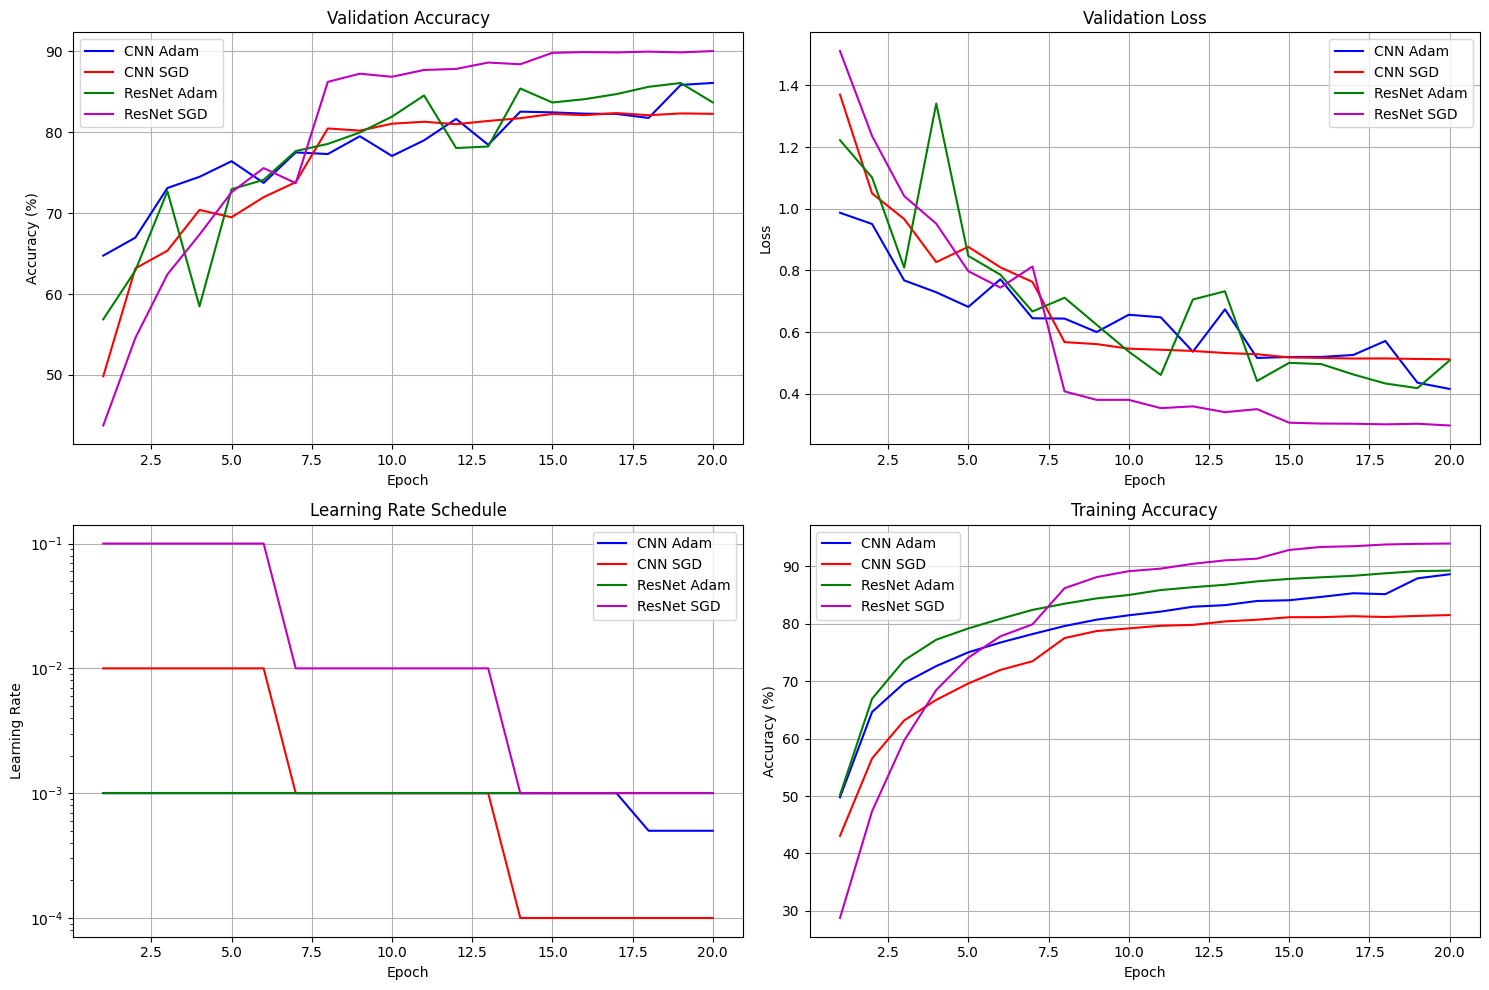

In [8]:
# Compare all 4 models
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, 21)

# Validation Accuracy
axes[0,0].plot(epochs, hist_cnn_adam['val_acc'], 'b-', label='CNN Adam')
axes[0,0].plot(epochs, hist_cnn_sgd['val_acc'], 'r-', label='CNN SGD')
axes[0,0].plot(epochs, hist_resnet_adam['val_acc'], 'g-', label='ResNet Adam')
axes[0,0].plot(epochs, hist_resnet_sgd['val_acc'], 'm-', label='ResNet SGD')
axes[0,0].set_title('Validation Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy (%)')
axes[0,0].legend()
axes[0,0].grid(True)

# Validation Loss
axes[0,1].plot(epochs, hist_cnn_adam['val_loss'], 'b-', label='CNN Adam')
axes[0,1].plot(epochs, hist_cnn_sgd['val_loss'], 'r-', label='CNN SGD')
axes[0,1].plot(epochs, hist_resnet_adam['val_loss'], 'g-', label='ResNet Adam')
axes[0,1].plot(epochs, hist_resnet_sgd['val_loss'], 'm-', label='ResNet SGD')
axes[0,1].set_title('Validation Loss')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

# Learning Rate
axes[1,0].plot(epochs, hist_cnn_adam['lrs'], 'b-', label='CNN Adam')
axes[1,0].plot(epochs, hist_cnn_sgd['lrs'], 'r-', label='CNN SGD')
axes[1,0].plot(epochs, hist_resnet_adam['lrs'], 'g-', label='ResNet Adam')
axes[1,0].plot(epochs, hist_resnet_sgd['lrs'], 'm-', label='ResNet SGD')
axes[1,0].set_title('Learning Rate Schedule')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Learning Rate')
axes[1,0].legend()
axes[1,0].grid(True)
axes[1,0].set_yscale('log')

# Training Accuracy
axes[1,1].plot(epochs, hist_cnn_adam['train_acc'], 'b-', label='CNN Adam')
axes[1,1].plot(epochs, hist_cnn_sgd['train_acc'], 'r-', label='CNN SGD')
axes[1,1].plot(epochs, hist_resnet_adam['train_acc'], 'g-', label='ResNet Adam')
axes[1,1].plot(epochs, hist_resnet_sgd['train_acc'], 'm-', label='ResNet SGD')
axes[1,1].set_title('Training Accuracy')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Accuracy (%)')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

Analyzing CNN (Adam + ReduceLROnPlateau) - Best performing model


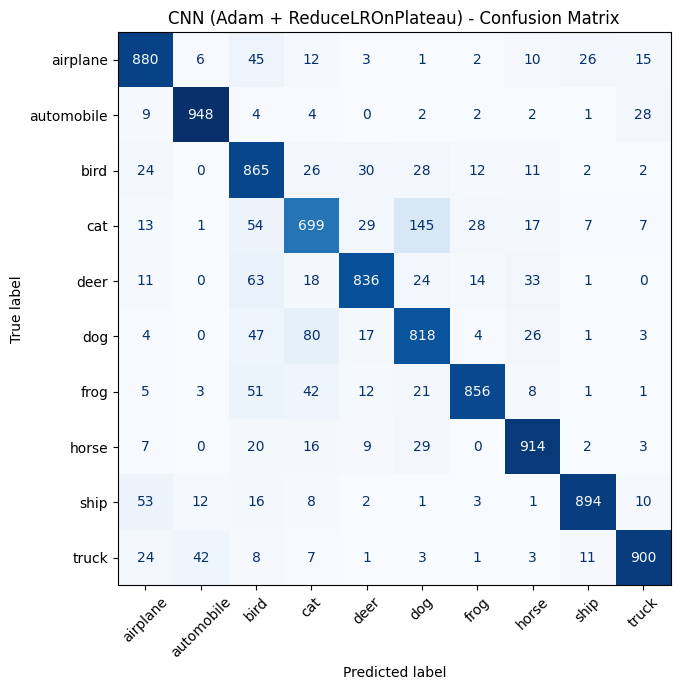

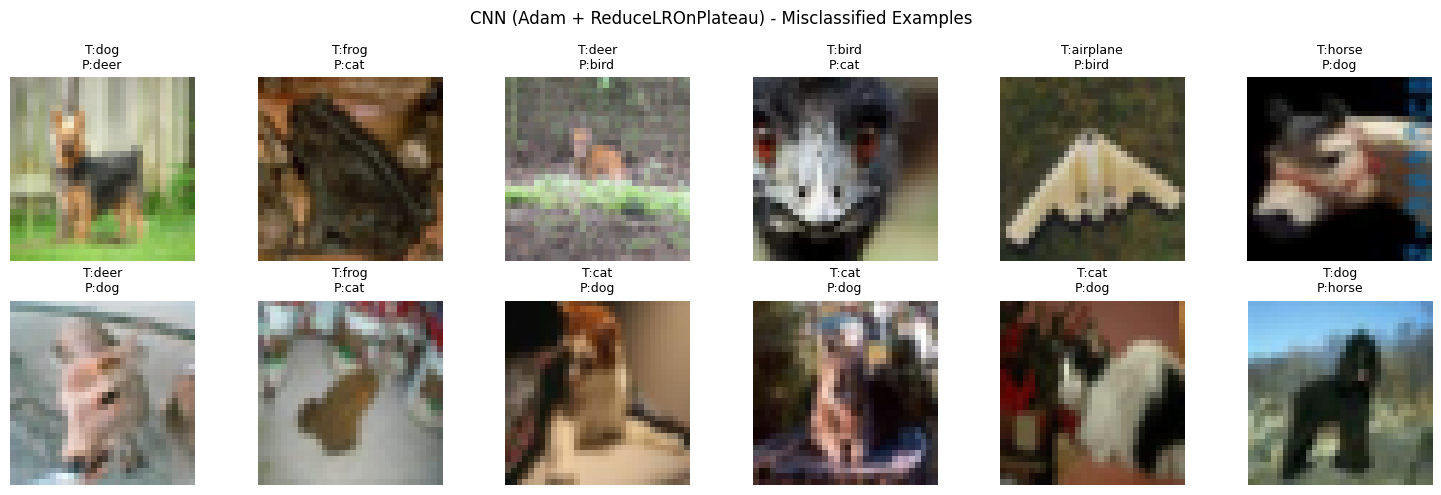

In [9]:
# Determine and analyze the best performing model
best_acc_adam = max(hist_cnn_adam['val_acc'])
best_acc_sgd = max(hist_cnn_sgd['val_acc'])

if best_acc_adam > best_acc_sgd:
    best_model = cnn_adam
    best_name = "CNN (Adam + ReduceLROnPlateau)"
else:
    best_model = cnn_sgd
    best_name = "CNN (SGD + StepLR)"

print(f"Analyzing {best_name} - Best performing model")
cm, preds, labels, imgs = confusion_and_misclassified(best_model, testloader)

# Show confusion matrix
show_confusion_matrix(cm, title=f"{best_name} - Confusion Matrix")

# Show some misclassified examples
show_misclassified(imgs, labels, preds, title=f"{best_name} - Misclassified Examples")

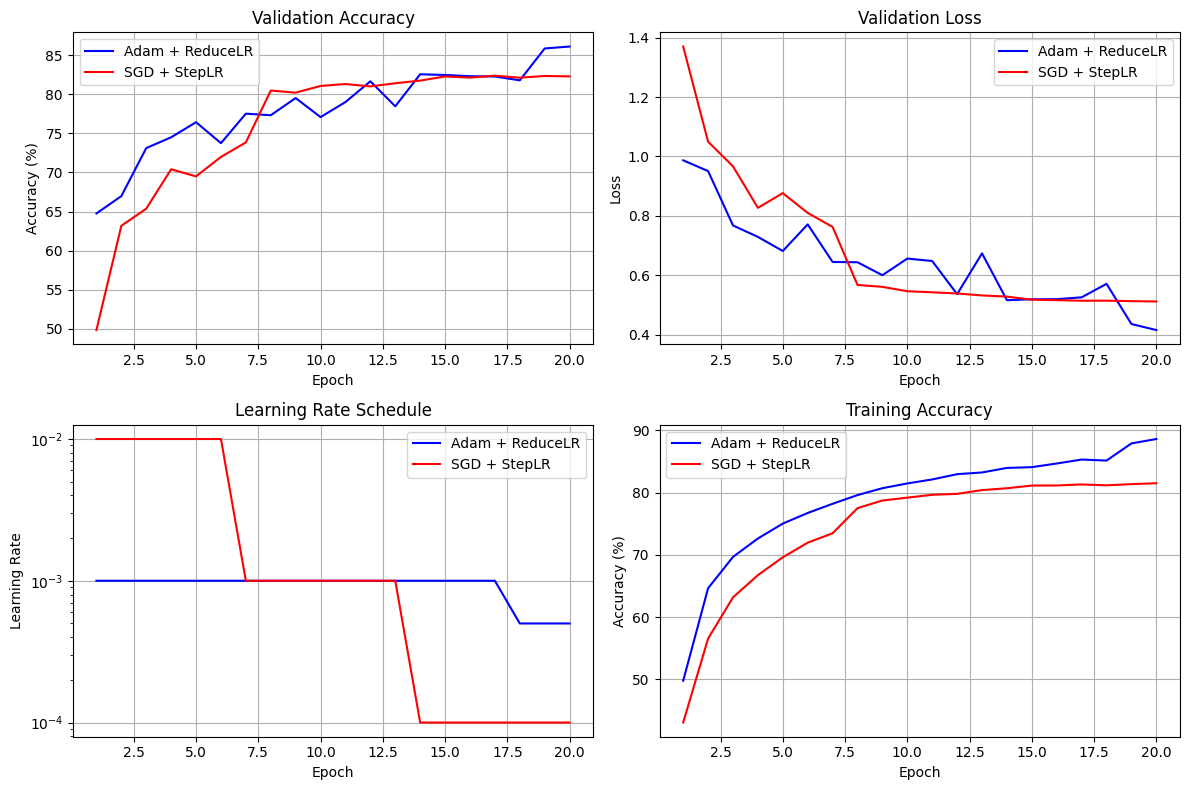

In [10]:
# Compare learning curves side by side
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

epochs_adam = range(1, len(hist_cnn_adam['val_acc'])+1)
epochs_sgd = range(1, len(hist_cnn_sgd['val_acc'])+1)

# Accuracy comparison
axes[0,0].plot(epochs_adam, hist_cnn_adam['val_acc'], 'b-', label='Adam + ReduceLR')
axes[0,0].plot(epochs_sgd, hist_cnn_sgd['val_acc'], 'r-', label='SGD + StepLR')
axes[0,0].set_title('Validation Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy (%)')
axes[0,0].legend()
axes[0,0].grid(True)

# Loss comparison
axes[0,1].plot(epochs_adam, hist_cnn_adam['val_loss'], 'b-', label='Adam + ReduceLR')
axes[0,1].plot(epochs_sgd, hist_cnn_sgd['val_loss'], 'r-', label='SGD + StepLR')
axes[0,1].set_title('Validation Loss')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

# Learning rate comparison
axes[1,0].plot(epochs_adam, hist_cnn_adam['lrs'], 'b-', label='Adam + ReduceLR')
axes[1,0].plot(epochs_sgd, hist_cnn_sgd['lrs'], 'r-', label='SGD + StepLR')
axes[1,0].set_title('Learning Rate Schedule')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Learning Rate')
axes[1,0].legend()
axes[1,0].grid(True)
axes[1,0].set_yscale('log')

# Training accuracy comparison
axes[1,1].plot(epochs_adam, hist_cnn_adam['train_acc'], 'b-', label='Adam + ReduceLR')
axes[1,1].plot(epochs_sgd, hist_cnn_sgd['train_acc'], 'r-', label='SGD + StepLR')
axes[1,1].set_title('Training Accuracy')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Accuracy (%)')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Final comparison and analysis
results = [
    (max(hist_cnn_adam['val_acc']), 'CNN (Adam + ReduceLR)', cnn_adam),
    (max(hist_cnn_sgd['val_acc']), 'CNN (SGD + StepLR)', cnn_sgd),
    (max(hist_resnet_adam['val_acc']), 'ResNet18 (Adam + ReduceLR)', resnet_adam),
    (max(hist_resnet_sgd['val_acc']), 'ResNet18 (SGD + StepLR)', resnet_sgd)
]

print("=== FINAL RESULTS ===")
for acc, name, _ in sorted(results, reverse=True):
    print(f"{name}: {acc:.2f}%")

best_acc, best_name, best_model = max(results)
print(f"\nBest Model: {best_name} ({best_acc:.2f}%)")

# Save best model
torch.save(best_model.state_dict(), 'best_model.pth')
print("Best model saved as 'best_model.pth'")

=== FINAL RESULTS ===
ResNet18 (SGD + StepLR): 90.04%
CNN (Adam + ReduceLR): 86.10%
ResNet18 (Adam + ReduceLR): 86.09%
CNN (SGD + StepLR): 82.37%

Best Model: ResNet18 (SGD + StepLR) (90.04%)
Best model saved as 'best_model.pth'
